# Comparision on traditional compression methods

## 1. Importing modules

In [2]:
import os
import csv
import io
import numpy as np
import cv2
from kornia.losses import PSNRLoss, SSIMLoss
from torchmetrics.image import VisualInformationFidelity
import PIL
Image = PIL.Image
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision.transforms as transforms
import compressai
from concurrent.futures import ThreadPoolExecutor
from compressai.zoo import models

/workspace/user/user6/.local/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/workspace/user/user6/.local/lib/python3.8/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
print(os.getcwd())

/workspace/user/user6/NIC-project/experiments


In [3]:
# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_images = f"/workspace/user/user6/NIC-project/experiments/image_compression/"
# Load Kodak dataset
kodak_path = [f"{path_images}/kodak/kodim{i:02}.png" for i in range(1, 25)]
kodak_PIL = [Image.open(i).convert('RGB') for i in kodak_path]
preprocess = transforms.Compose([transforms.ToTensor()])
kodak_Tensor = [preprocess(img).unsqueeze(0).to(device) for img in kodak_PIL]


## 2. Compression using pillow library and collection of metrics

In [ ]:
def compress_pillow(image_rgb,types,quality):
    # types in {"jpeg", "webp","jpeg2000"}
    # quality is from 0 to 100, return the image and the bpp
    sizes = image_rgb.size
    temp = io.BytesIO()
    if types in ["jpeg","webp"]:
        image_rgb.save(temp,format = types,quality = quality)
    elif types == "jpeg2000":
        image_rgb.save(temp, format="JPEG2000", quality_mode="rates", quality_layers=[quality])
    else:
        raise ValueError(f"Invalid image type: {types}")
    temp.seek(0)
    filesize = temp.getbuffer().nbytes
    bpp = filesize*8.0/(sizes[0]*sizes[1])
    jpeg_compressed = Image.open(temp)
    return jpeg_compressed,bpp

def to_tensor(image_rgb):
    preprocess = transforms.Compose([
        transforms.ToTensor()
    ])
    return preprocess(image_rgb).unsqueeze(0)
    
def PSNR(x,y,max_val):
    psnr = PSNRLoss(max_val=max_val)
    return -psnr(x,y).item()
def SSIM(x,y):
    ssim_loss = SSIMLoss(window_size=11, reduction='mean')
    ssim_value = 1-ssim_loss(x,y).item()
    return ssim_value
def VIF(x,y):
    vif = VisualInformationFidelity().to(device)
    return vif(x,y).item()

    

## 3. Process of jpeg compression

In [5]:


def process_image(quality):
    image_rgb = kodak_PIL[i]
    jpeg_compressed, bpp = compress_pillow(image_rgb, "jpeg", quality)
    x = kodak_Tensor[i].to(device)
    y = to_tensor(jpeg_compressed).to(device)
    jpeg_metrics[i, quality, 0] = bpp
    jpeg_metrics[i, quality, 1] = SSIM(x, y)
    jpeg_metrics[i, quality, 2] = VIF(x, y)
    jpeg_metrics[i, quality, 3] = PSNR(x, y, max_val=1.0)
    
    print(f"kodim{i}, quality: {quality}, bpp: {bpp}, ssim: {jpeg_metrics[i, quality, 1]}, vif: {jpeg_metrics[i, quality, 2]}, psnr: {jpeg_metrics[i, quality, 3]} ")
    del x, y  # free memory
    torch.cuda.empty_cache()

print("process of jpeg compression")

jpeg_metrics = np.empty((24, 101, 4))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_cpu = os.cpu_count()
print(f"num_cpu: {num_cpu}")

for i in range(24):
    with ThreadPoolExecutor(max_workers=num_cpu) as executor:
        futures = [executor.submit(process_image, quality) for quality in range(1,101)]
        for future in futures:
            future.result()
jpeg_bpp = jpeg_metrics[:, :, 0]
jpeg_ssim = jpeg_metrics[:, :, 1]
jpeg_vif = jpeg_metrics[:, :, 2]
jpeg_psnr = jpeg_metrics[:, :, 3]

data = []
for i in range(24):
    for quality in range(1, 101):
        bpp = jpeg_metrics[i, quality, 0]
        ssim = jpeg_metrics[i, quality, 1]
        vif = jpeg_metrics[i, quality, 2]
        psnr = jpeg_metrics[i, quality, 3]
        data.append([i+1, quality, bpp, ssim, vif, psnr])

columns = ["kodak", "quality","bpp", "ssim", "vif", "psnr"]
df = pd.DataFrame(data,columns=columns)
df.to_csv(f"{path_images}/csv/jpeg_metrics.csv", index=False)


process of jpeg compression
num_cpu: 96
kodim0, quality: 36, bpp: 1.0365397135416667, ssim: 0.9292212203145027, vif: 0.8907713890075684, psnr: 28.825281143188477 
kodim0, quality: 6, bpp: 0.3046875, ssim: 0.8024593591690063, vif: 0.7132530212402344, psnr: 22.886354446411133 
kodim0, quality: 12, bpp: 0.5003255208333334, ssim: 0.8626676648855209, vif: 0.8062394261360168, psnr: 25.30571746826172 
kodim0, quality: 21, bpp: 0.7361043294270834, ssim: 0.9014182761311531, vif: 0.8576763272285461, psnr: 27.106441497802734 
kodim0, quality: 1, bpp: 0.19089762369791666, ssim: 0.7123300135135651, vif: 0.5084725022315979, psnr: 19.94636344909668 
kodim0, quality: 25, bpp: 0.82464599609375, ssim: 0.9104678854346275, vif: 0.869720995426178, psnr: 27.662437438964844 
kodim0, quality: 27, bpp: 0.86468505859375, ssim: 0.9147686064243317, vif: 0.8747314810752869, psnr: 27.90760040283203 
kodim0, quality: 4, bpp: 0.2388916015625, ssim: 0.757379949092865, vif: 0.5923035740852356, psnr: 21.017484664916992 

## 4. Process of jpeg2000 compression

In [6]:


def process_image(quality):
    image_rgb = kodak_PIL[i]
    jpeg_compressed, bpp = compress_pillow(image_rgb, "jpeg2000", quality)
    x = kodak_Tensor[i].to(device)
    y = to_tensor(jpeg_compressed).to(device)
    jpeg2000_metrics[i, quality, 0] = bpp
    jpeg2000_metrics[i, quality, 1] = SSIM(x, y)
    jpeg2000_metrics[i, quality, 2] = VIF(x, y)
    jpeg2000_metrics[i, quality, 3] = PSNR(x, y, max_val=1.0)
    
    print(f"kodim{i}, quality: {quality}, bpp: {bpp}, ssim: {jpeg2000_metrics[i, quality, 1]}, vif: {jpeg2000_metrics[i, quality, 2]}, psnr: {jpeg2000_metrics[i, quality, 3]} ")
    del x, y  # free memory
    torch.cuda.empty_cache()

print("process of jpeg2000 compression")

jpeg2000_metrics = np.empty((24, 101, 4))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_cpu = os.cpu_count()
print(f"num_cpu: {num_cpu}")

for i in range(24):
    with ThreadPoolExecutor(max_workers=num_cpu) as executor:
        futures = [executor.submit(process_image, quality) for quality in range(1,101)]
        for future in futures:
            future.result()
jpeg2000_bpp = jpeg2000_metrics[:, :, 0]
jpeg2000_ssim = jpeg2000_metrics[:, :, 1]
jpeg2000_vif = jpeg2000_metrics[:, :, 2]
jpeg2000_psnr = jpeg2000_metrics[:, :, 3]

data = []
for i in range(24):
    for quality in range(1, 101):
        data.append([i, quality, jpeg2000_bpp[i, quality], jpeg2000_ssim[i, quality], jpeg2000_vif[i, quality], jpeg2000_psnr[i, quality]])
df = pd.DataFrame(data, columns=["kodak", "quality", "bpp", "ssim", "vif", "psnr"])
df.to_csv(f"{path_images}/csv/jpeg2000_metrics.csv", index=False)



process of jpeg2000 compression
num_cpu: 96
kodim0, quality: 51, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 22, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 12, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 47, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 26, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 25, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 2, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.71233367919922 
kodim0, quality: 41, bpp: 0.25030517578125, ssim: 0.7558484375476837, vif: 0.8983694911003113, psnr: 22.7123336791992

## 5. Process of webp compression

In [7]:


def process_image(quality):
    image_rgb = kodak_PIL[i]
    jpeg_compressed, bpp = compress_pillow(image_rgb, "webp", quality)
    x = kodak_Tensor[i].to(device)
    y = to_tensor(jpeg_compressed).to(device)
    webp_metrics[i, quality, 0] = bpp
    webp_metrics[i, quality, 1] = SSIM(x, y)
    webp_metrics[i, quality, 2] = VIF(x, y)
    webp_metrics[i, quality, 3] = PSNR(x, y, max_val=1.0)
    
    print(f"kodim{i}, quality: {quality}, bpp: {bpp}, ssim: {webp_metrics[i, quality, 1]}, vif: {webp_metrics[i, quality, 2]}, psnr: {webp_metrics[i, quality, 3]} ")
    del x, y  # free memory
    torch.cuda.empty_cache()

print("process of jpeg2000 compression")

webp_metrics = np.empty((24, 101, 4))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_cpu = os.cpu_count()
print(f"num_cpu: {num_cpu}")

for i in range(24):
    with ThreadPoolExecutor(max_workers=num_cpu) as executor:
        futures = [executor.submit(process_image, quality) for quality in range(1,101)]
        for future in futures:
            future.result()
webp_bpp = webp_metrics[:, :, 0]
webp_ssim = webp_metrics[:, :, 1]
webp_vif = webp_metrics[:, :, 2]
webp_psnr = webp_metrics[:, :, 3]

data = []
for i in range(24):
    for quality in range(1, 101):
        data.append([i, quality, webp_bpp[i, quality], webp_ssim[i, quality], webp_vif[i, quality], webp_psnr[i, quality]])
df = pd.DataFrame(data, columns=['kodak', 'quality', 'bpp', 'ssim', 'vif', 'psnr'])

df.to_csv(f"{path_images}/csv/webp_metrics.csv", index=False)


process of jpeg2000 compression
num_cpu: 96
kodim0, quality: 9, bpp: 0.4322916666666667, ssim: 0.8821129649877548, vif: 0.9293404221534729, psnr: 26.90423583984375 
kodim0, quality: 7, bpp: 0.3925374348958333, ssim: 0.872522845864296, vif: 0.9411589503288269, psnr: 26.556133270263672 
kodim0, quality: 12, bpp: 0.4872233072916667, ssim: 0.8938674479722977, vif: 0.9175873398780823, psnr: 27.35132598876953 
kodim0, quality: 10, bpp: 0.452880859375, ssim: 0.8872875273227692, vif: 0.9141778349876404, psnr: 27.05942153930664 
kodim0, quality: 16, bpp: 0.5638834635416666, ssim: 0.9069178774952888, vif: 0.9145185351371765, psnr: 27.921390533447266 
kodim0, quality: 8, bpp: 0.4108072916666667, ssim: 0.8778595924377441, vif: 0.93410724401474, psnr: 26.736495971679688 
kodim0, quality: 2, bpp: 0.2691243489583333, ssim: 0.8375763297080994, vif: 0.9735550880432129, psnr: 25.39267349243164 
kodim0, quality: 6, bpp: 0.3686116536458333, ssim: 0.8651663959026337, vif: 0.9649827480316162, psnr: 26.33417

## 6. Process of Cheng2020-anchor and Cheng2020-attn of Quality [1,6]

In [ ]:

def BPP(image_tensor,model, num_pixels):
    output = model(image_tensor)
    # Calculate BPP
    bpp = sum(
        torch.log(likelihoods).sum() / (-np.log(2) * num_pixels)
        for likelihoods in output["likelihoods"].values()
    )
    return bpp.item()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def process_image(i):
    model_name,quality = x
    model_class = models[model_name]
    model = model_class(quality = quality, pretrained = True).to(device)
    img = kodak_Tensor[i].to(device)
    img_comp = model(img)["x_hat"].to(device)
    img_comp = img_comp.clamp(0, 1)
    num_pixels = img_comp.shape[0] * img_comp.shape[-1] * img_comp.shape[-2]
    if model_name == "cheng2020-anchor":
        cheng2020_anchor_metrics[i, quality, 0] = BPP(img,model, num_pixels)
        cheng2020_anchor_metrics[i, quality, 1] = SSIM(img, img_comp)
        cheng2020_anchor_metrics[i, quality, 2] = VIF(img, img_comp)
        cheng2020_anchor_metrics[i, quality, 3] = PSNR(img, img_comp, max_val=1.0)
        print(f"model: {model_name}, kodim{i}, quality: {quality}, bpp: {cheng2020_anchor_metrics[i, quality, 0]}, ssim: {cheng2020_anchor_metrics[i, quality, 1]}, vif: {cheng2020_anchor_metrics[i, quality, 2]}, psnr: {cheng2020_anchor_metrics[i, quality, 3]} ")
    elif model_name == "cheng2020-attn":
        cheng2020_attn_metrics[i, quality, 0] = BPP(img,model, num_pixels)
        cheng2020_attn_metrics[i, quality, 1] = SSIM(img, img_comp)
        cheng2020_attn_metrics[i, quality, 2] = VIF(img, img_comp)
        cheng2020_attn_metrics[i, quality, 3] = PSNR(img, img_comp, max_val=1.0)
        print(f"model: {model_name}, kodim{i}, quality: {quality}, bpp: {cheng2020_attn_metrics[i, quality, 0]}, ssim: {cheng2020_attn_metrics[i, quality, 1]}, vif: {cheng2020_attn_metrics[i, quality, 2]}, psnr: {cheng2020_attn_metrics[i, quality, 3]} ")
    del img_comp, img, model  # free memory
    torch.cuda.empty_cache()

cheng2020_anchor_metrics = np.empty((24, 7, 4))
cheng2020_attn_metrics = np.empty((24, 7,4))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_cpu = os.cpu_count()
print(f"num_cpu: {num_cpu}")

for x in [("cheng2020-anchor",1),("cheng2020-anchor",2),("cheng2020-anchor",3),("cheng2020-anchor",4),("cheng2020-anchor",5),("cheng2020-anchor",6),("cheng2020-attn",1),("cheng2020-attn",2),("cheng2020-attn",3),("cheng2020-attn",4),("cheng2020-attn",5),("cheng2020-attn",6)]:
    for i in range(24):
        process_image(i)
    
anchor_bpp = cheng2020_anchor_metrics[:,:,0]
anchor_ssim = cheng2020_anchor_metrics[:,:,1]
anchor_vif = cheng2020_anchor_metrics[:,:,2]
anchor_psnr = cheng2020_anchor_metrics[:,:,3]
attn_bpp = cheng2020_attn_metrics[:,:,0]
attn_ssim = cheng2020_attn_metrics[:,:,1]
attn_vif = cheng2020_attn_metrics[:,:,2]
attn_psnr = cheng2020_attn_metrics[:,:,3]
data_anchor = []
data_attn = []
for i in range(24):
    for quality in range(1, 7):
        data_anchor.append([i, quality, anchor_bpp[i, quality], anchor_ssim[i, quality], anchor_vif[i, quality], anchor_psnr[i, quality]])
        data_attn.append([i, quality, attn_bpp[i, quality], attn_ssim[i, quality], attn_vif[i, quality], attn_psnr[i, quality]])
df_anchor = pd.DataFrame(data_anchor, columns=['kodak', 'quality', 'bpp', 'ssim', 'vif', 'psnr'])
df_attn = pd.DataFrame(data_attn, columns=['kodak', 'quality', 'bpp', 'ssim', 'vif', 'psnr'])

df_anchor.to_csv(f"{path_images}/csv/cheng2020-anchor_metrics.csv", index=False)    
df_attn.to_csv(f"{path_images}/csv/cheng2020-attn_metrics.csv", index=False)  


num_cpu: 96


model: cheng2020-anchor, kodim0, quality: 1, bpp: 0.2551913559436798, ssim: 0.859571635723114, vif: 1.001931071281433, psnr: 26.326101303100586 
model: cheng2020-anchor, kodim1, quality: 1, bpp: 0.1337507963180542, ssim: 0.8805181607604027, vif: 1.003842830657959, psnr: 30.36348533630371 
model: cheng2020-anchor, kodim2, quality: 1, bpp: 0.1312028020620346, ssim: 0.9283815920352936, vif: 0.9991753697395325, psnr: 31.86063003540039 
model: cheng2020-anchor, kodim3, quality: 1, bpp: 0.14691700041294098, ssim: 0.8885601907968521, vif: 1.0157986879348755, psnr: 30.166885375976562 
model: cheng2020-anchor, kodim4, quality: 1, bpp: 0.31727829575538635, ssim: 0.8928615301847458, vif: 1.0048989057540894, psnr: 26.63259506225586 
model: cheng2020-anchor, kodim5, quality: 1, bpp: 0.21548782289028168, ssim: 0.8797202408313751, vif: 1.008279800415039, psnr: 27.72644805908203 
model: cheng2020-anchor, kodim6, quality: 1, bpp: 0.18019650876522064, ssim: 0.9472615905106068, vif: 1.0157390832901, psnr

## 7. Plotting results

In [9]:
import os 
print(os.getcwd())

/workspace/user/user6/NIC-project/experiments


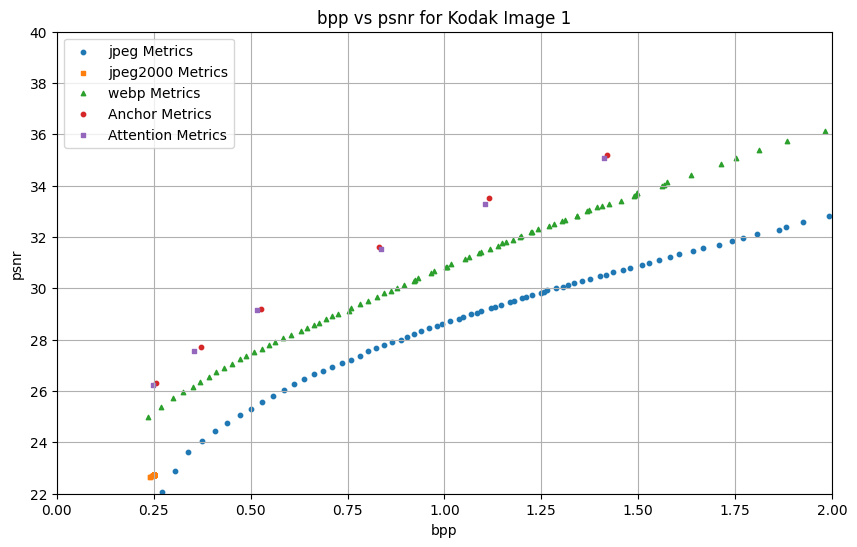

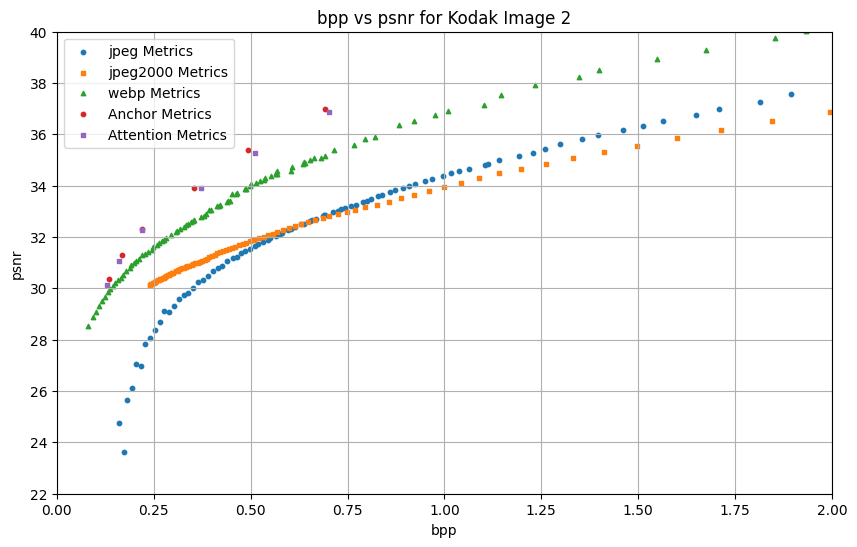

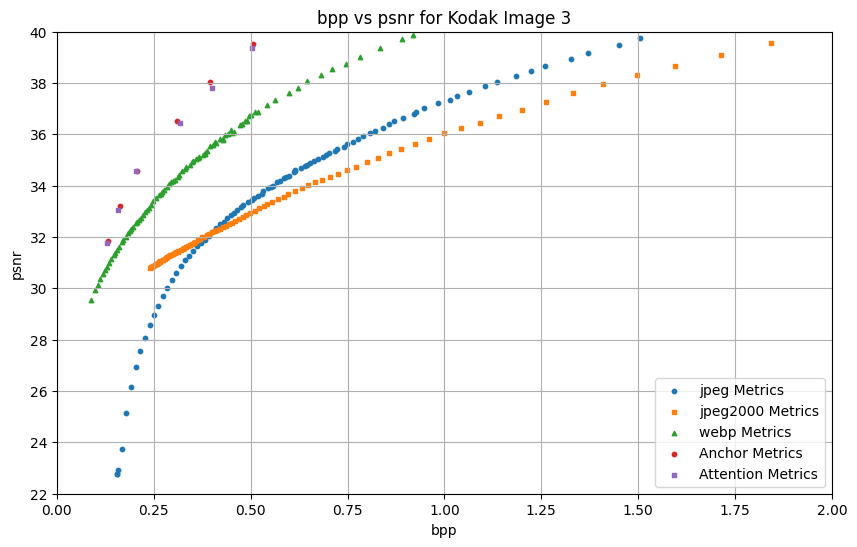

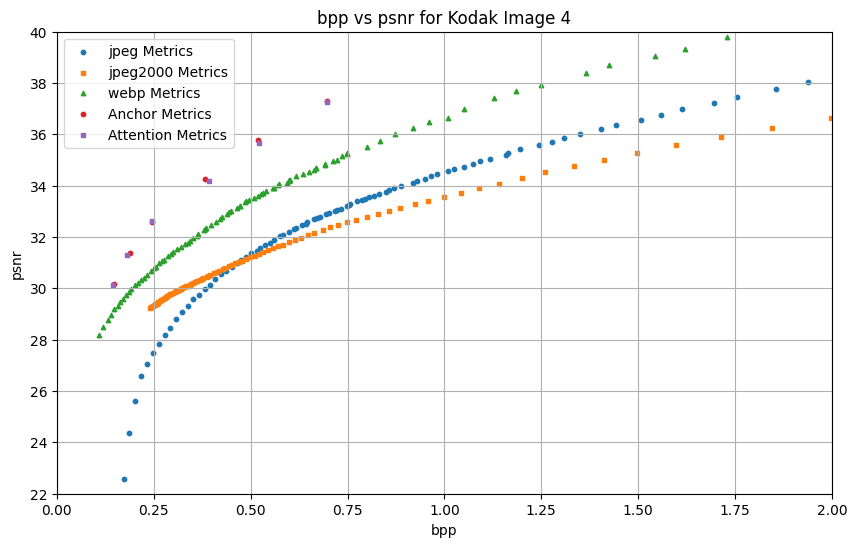

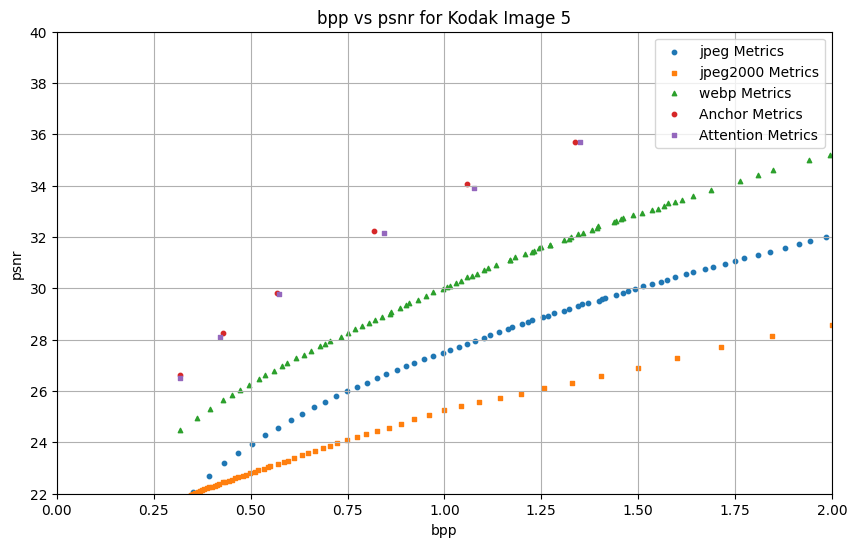

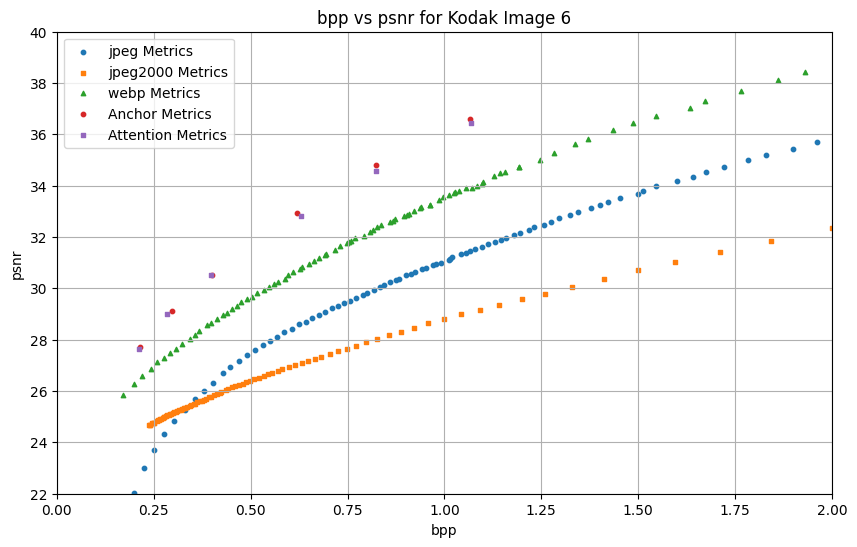

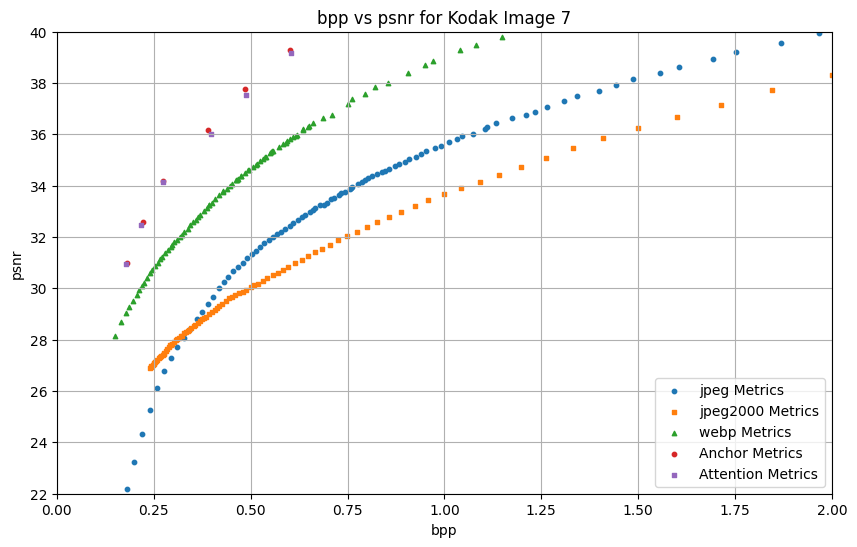

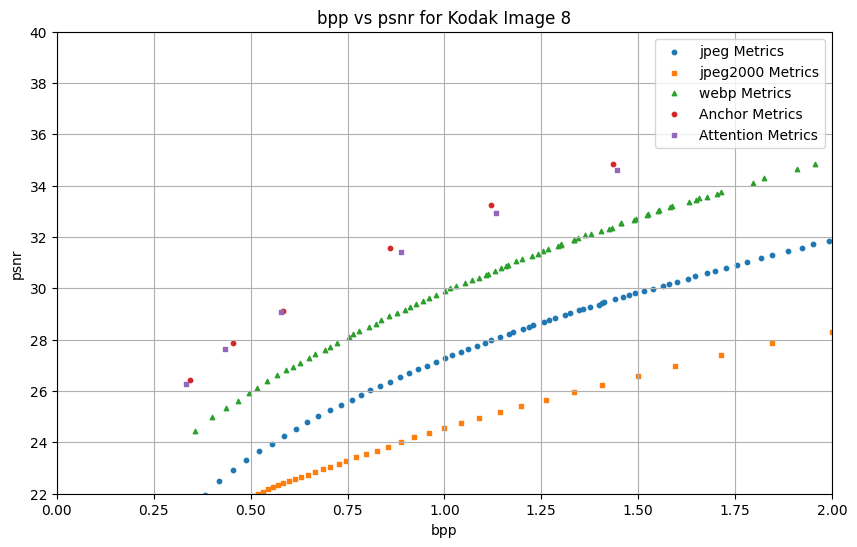

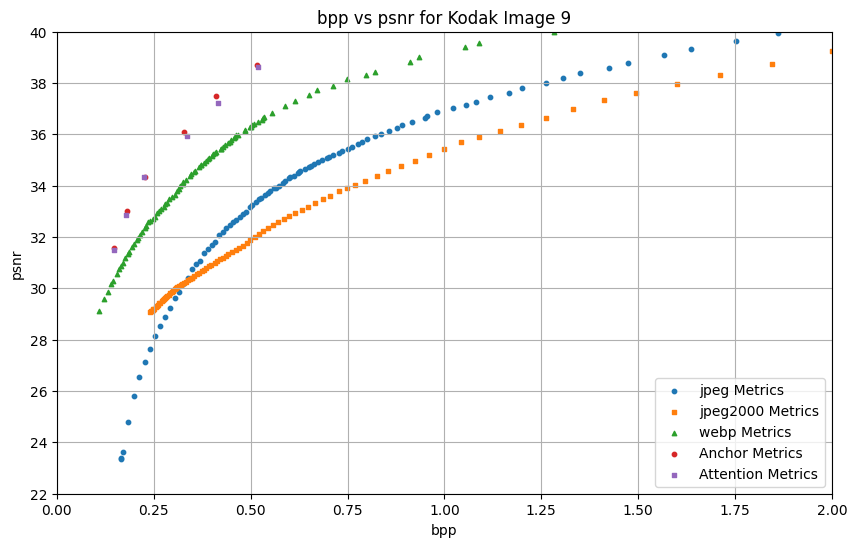

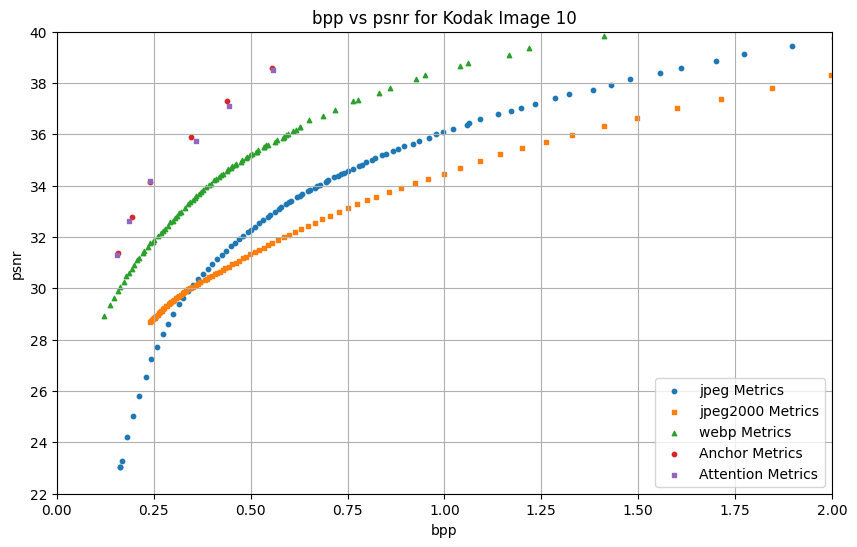

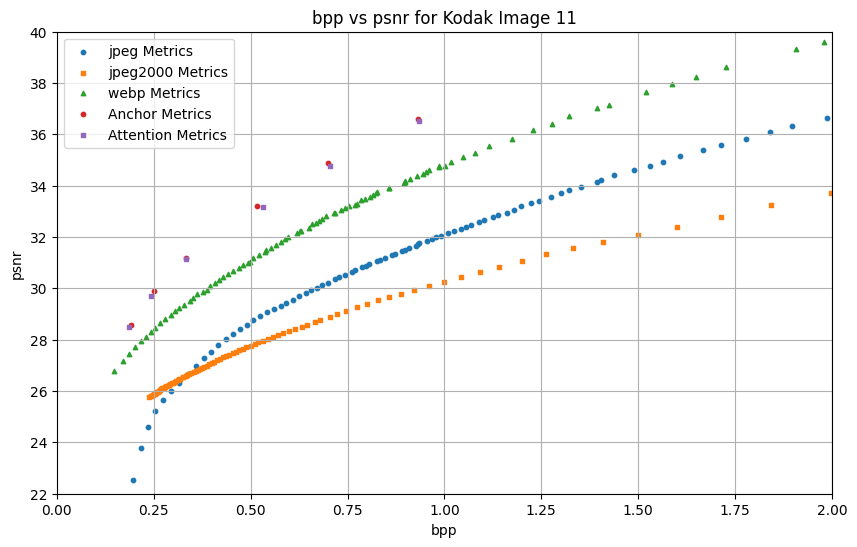

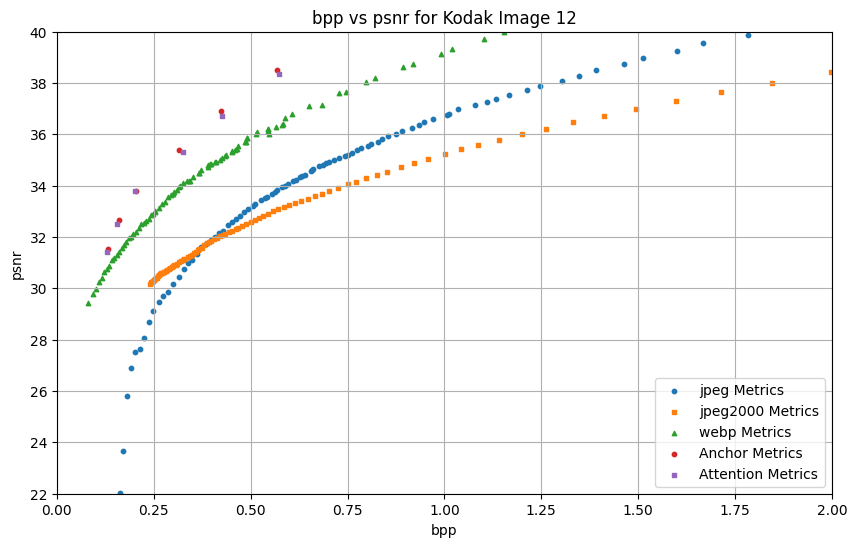

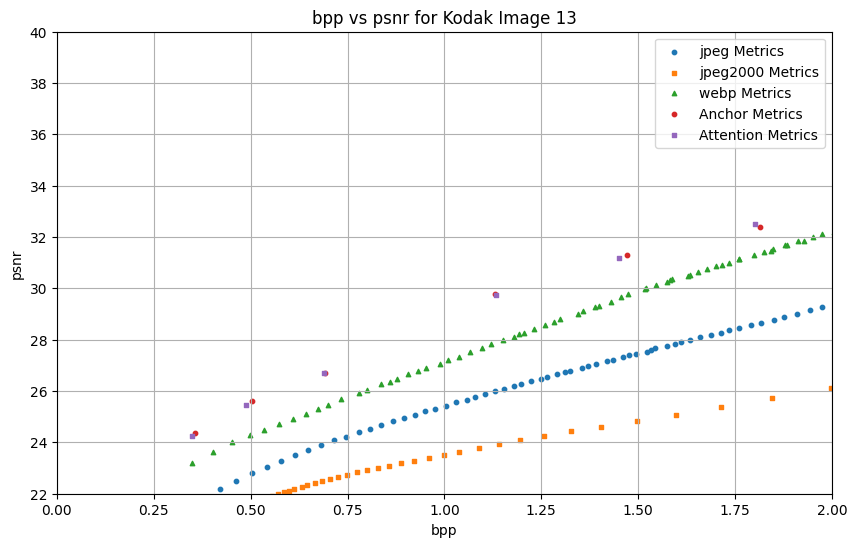

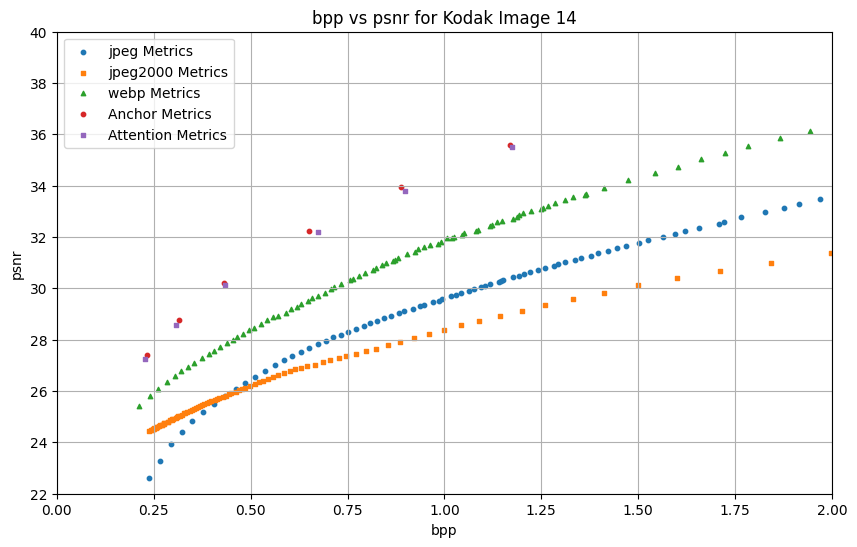

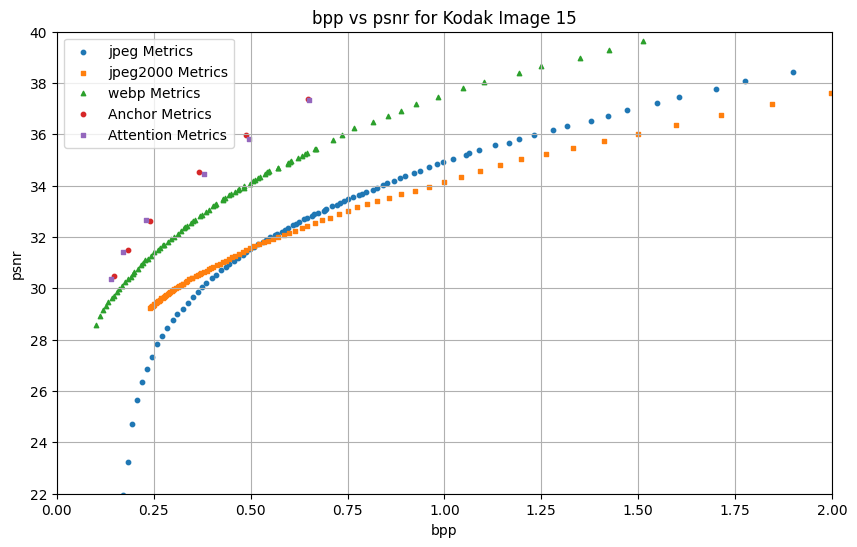

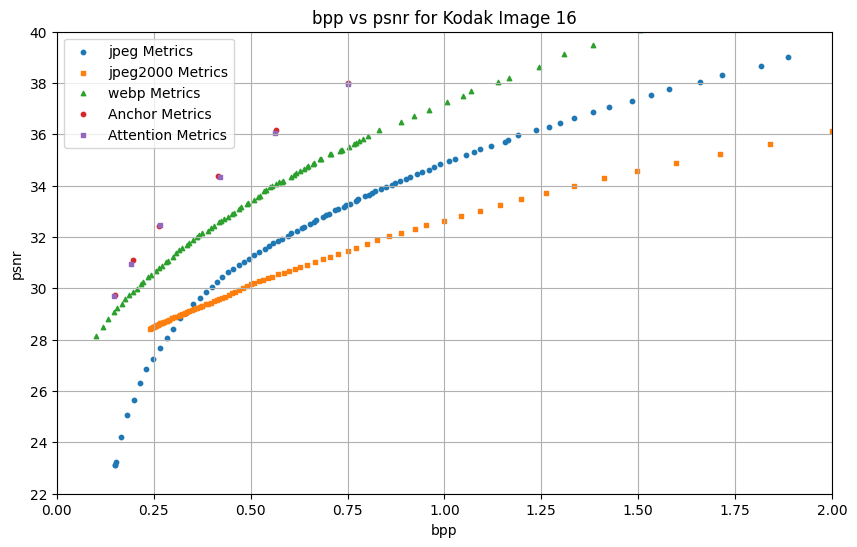

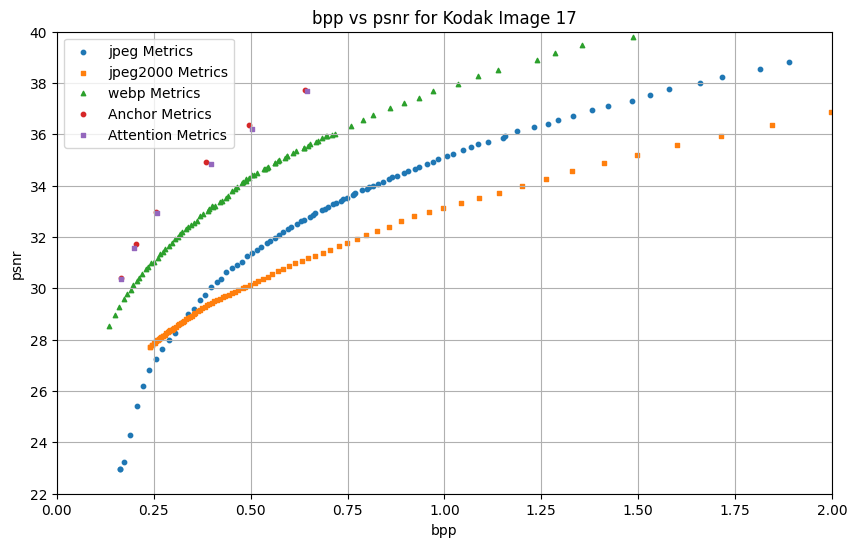

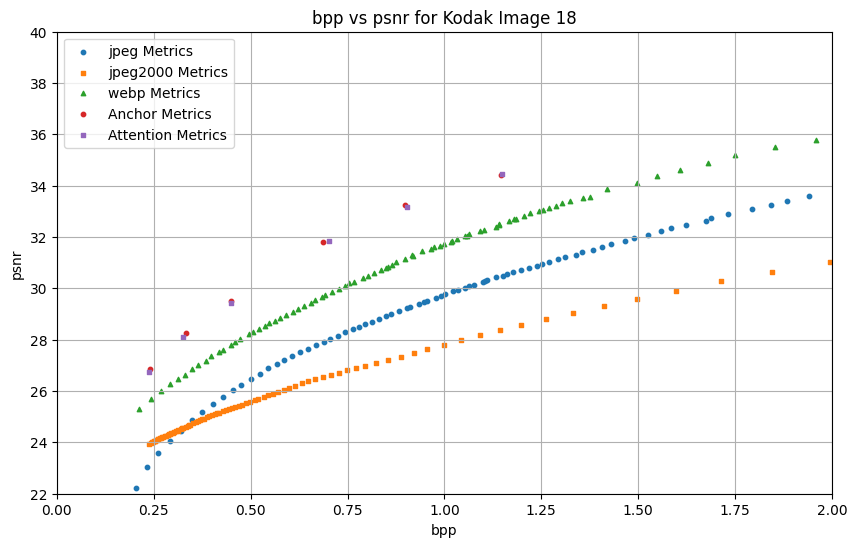

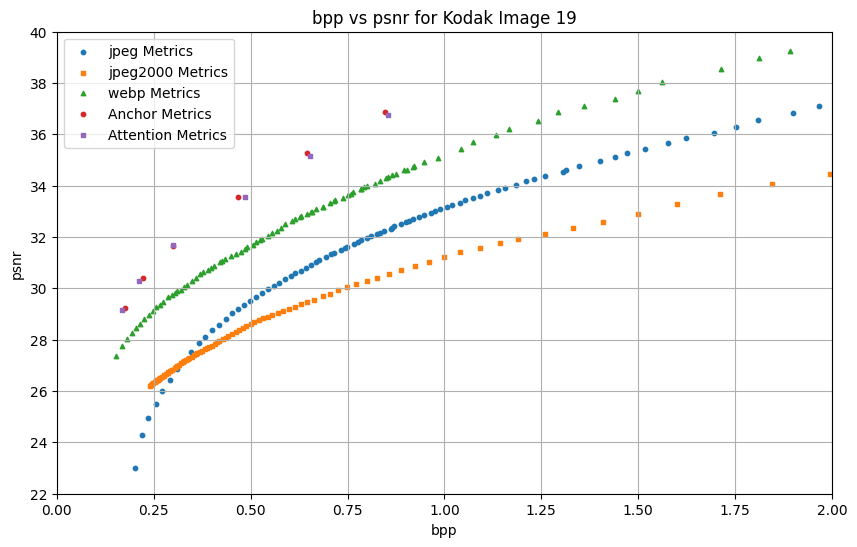

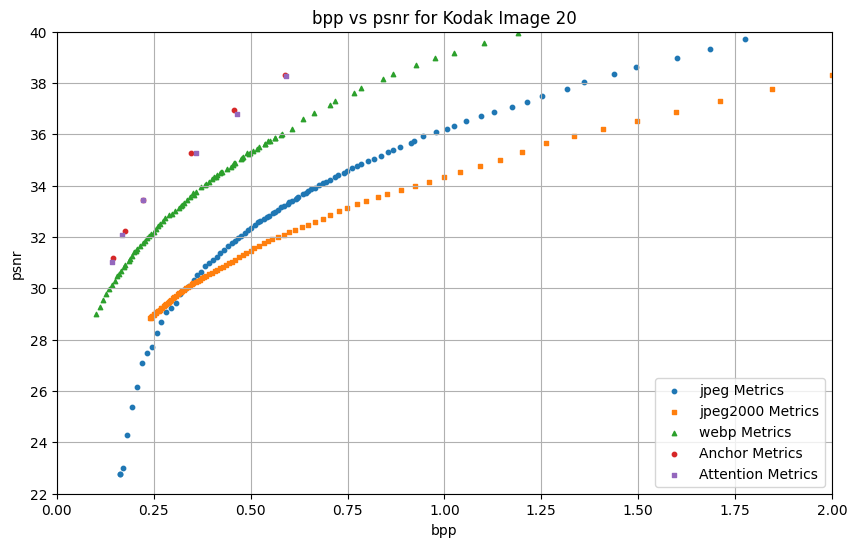

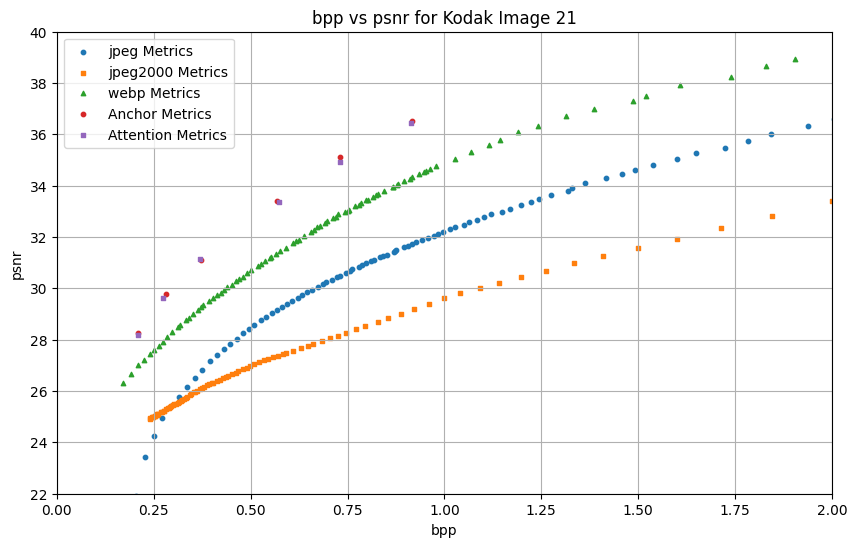

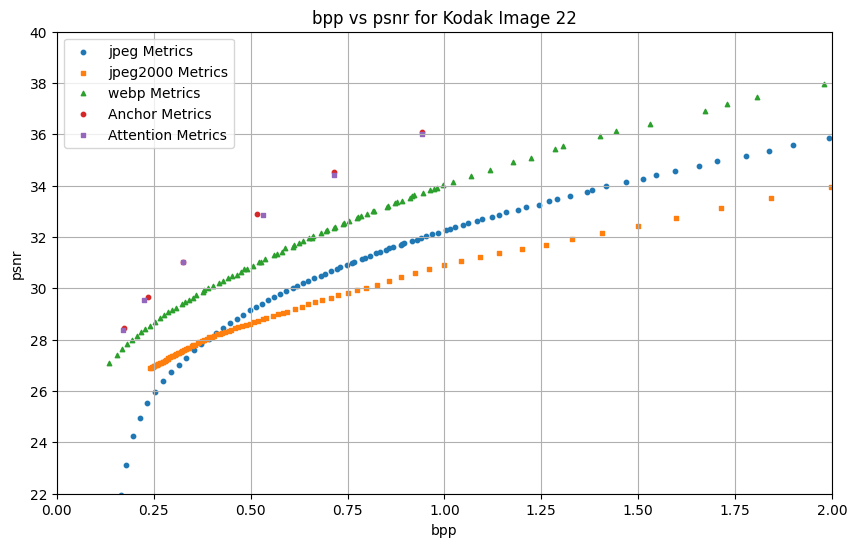

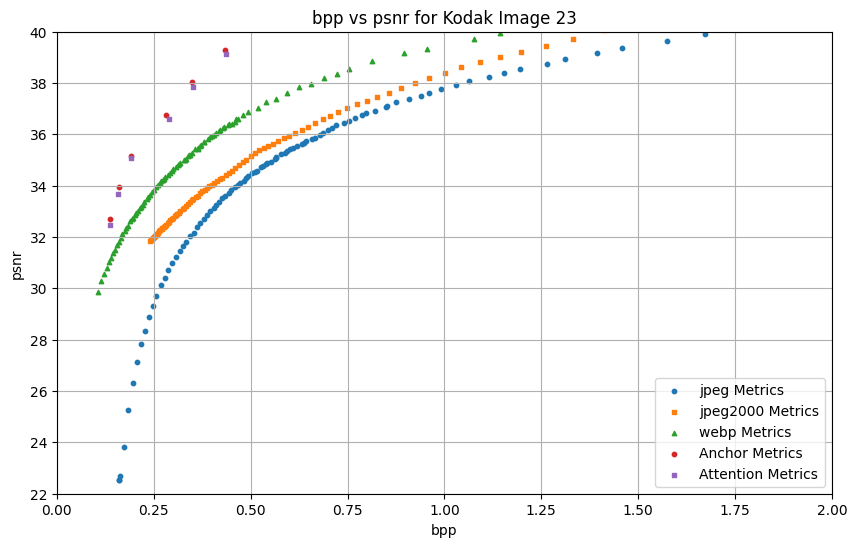

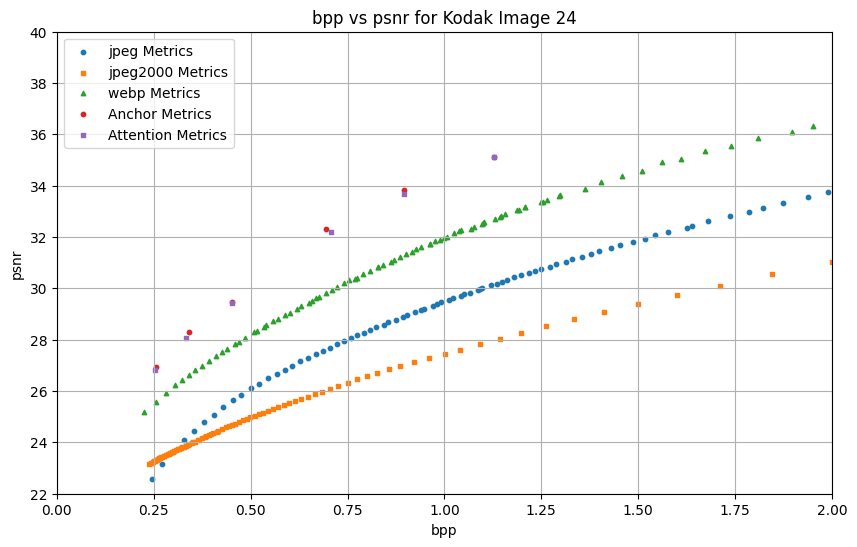

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

for image_id in range(0, 24):
    df1 = pd.read_csv("image_compression/csv/cheng2020-anchor_metrics.csv")
    df2 = pd.read_csv("image_compression/csv/cheng2020-attn_metrics.csv")
    df1 = df1[df1['kodak'] == image_id]
    df2 = df2[df2['kodak'] == image_id]
    df3 = pd.read_csv("image_compression/csv/jpeg_metrics.csv")
    df4 = pd.read_csv("image_compression/csv/jpeg2000_metrics.csv")
    df5 = pd.read_csv("image_compression/csv/webp_metrics.csv")

    df3 = df3[df3['kodak'] == image_id + 1]
    df4 = df4[df4['kodak'] == image_id]
    df5 = df5[df5['kodak'] == image_id]
    plt.figure(figsize=(10, 6))
    plt.scatter(df3['bpp'], df3['psnr'], label='jpeg Metrics', s=10, marker='o')
    plt.scatter(df4['bpp'], df4['psnr'], label='jpeg2000 Metrics', s=10, marker='s')
    plt.scatter(df5['bpp'], df5['psnr'], label='webp Metrics', s=10, marker='^')


    plt.scatter(df1['bpp'], df1['psnr'], label='Anchor Metrics', s=10, marker='o')
    plt.scatter(df2['bpp'], df2['psnr'], label='Attention Metrics', s=10, marker='s')
    plt.xlabel('bpp')
    plt.ylabel('psnr')
    plt.title(f'bpp vs psnr for Kodak Image {image_id + 1}')
    plt.legend()
    plt.grid(True)
    plt.xlim(0,2)
    plt.ylim(22,40)
    plt.show()



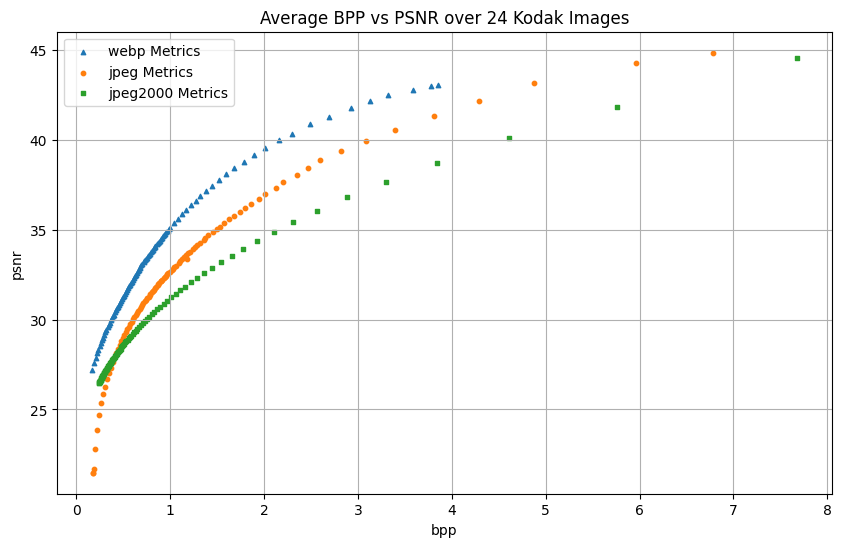

In [ ]:
mean_psnr_jpeg = []
mean_bpp_jpeg = []
mean_psnr_jpeg2000 = []
mean_bpp_jpeg2000 = []
mean_psnr_webp = []
mean_bpp_webp = []

for image_quality in range(1, 101):
    df3 = pd.read_csv("image_compression/csv/jpeg_metrics.csv")
    df4 = pd.read_csv("image_compression/csv/jpeg2000_metrics.csv")
    df5 = pd.read_csv("image_compression/csv/webp_metrics.csv")

    df3 = df3[df3['quality'] == image_quality]
    df4 = df4[df4['quality'] == image_quality]
    df5 = df5[df5['quality'] == image_quality]

    mean_psnr_jpeg.append(df3["psnr"].mean())
    mean_bpp_jpeg.append(df3["bpp"].mean())
    mean_psnr_jpeg2000.append(df4["psnr"].mean())
    mean_bpp_jpeg2000.append(df4["bpp"].mean())
    mean_psnr_webp.append(df5["psnr"].mean())
    mean_bpp_webp.append(df5["bpp"].mean())

plt.figure(figsize=(10, 6))
plt.scatter(mean_bpp_webp, mean_psnr_webp, label='webp Metrics', s=10, marker='^')
plt.scatter(mean_bpp_jpeg, mean_psnr_jpeg, label='jpeg Metrics', s=10, marker='o')
plt.scatter(mean_bpp_jpeg2000, mean_psnr_jpeg2000, label='jpeg2000 Metrics', s=10, marker='s')
plt.xlabel('bpp')
plt.ylabel('psnr')
plt.legend()
plt.title('Average BPP vs PSNR over 24 Kodak Images')
plt.grid(True)
plt.show()


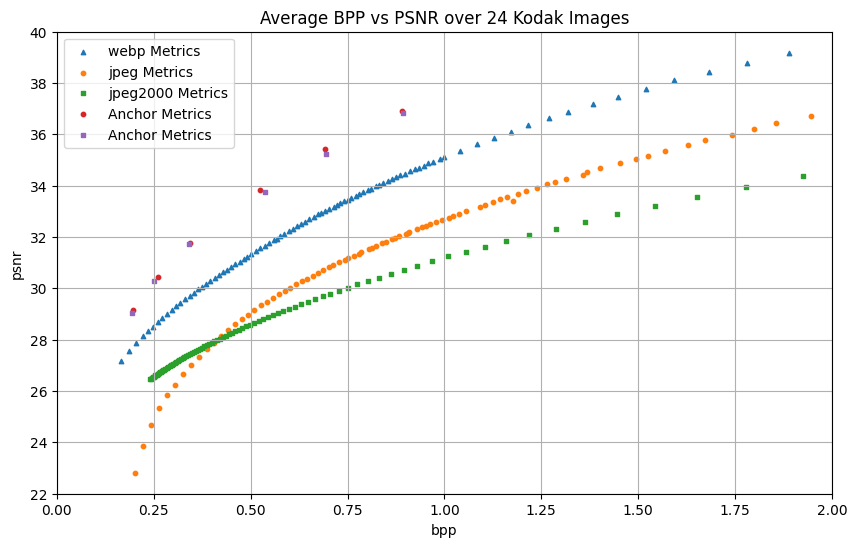

In [20]:
mean_psnr_jpeg = []
mean_bpp_jpeg = []
mean_psnr_jpeg2000 = []
mean_bpp_jpeg2000 = []
mean_psnr_webp = []
mean_bpp_webp = []
mean_psnr_attn = []
mean_bpp_attn = []
mean_psnr_anchor = []
mean_bpp_anchor = []


for image_quality in range(1, 101):
    df3 = pd.read_csv("image_compression/csv/jpeg_metrics.csv")
    df4 = pd.read_csv("image_compression/csv/jpeg2000_metrics.csv")
    df5 = pd.read_csv("image_compression/csv/webp_metrics.csv")

    df3 = df3[df3['quality'] == image_quality]
    df4 = df4[df4['quality'] == image_quality]
    df5 = df5[df5['quality'] == image_quality]

    mean_psnr_jpeg.append(df3["psnr"].mean())
    mean_bpp_jpeg.append(df3["bpp"].mean())
    mean_psnr_jpeg2000.append(df4["psnr"].mean())
    mean_bpp_jpeg2000.append(df4["bpp"].mean())
    mean_psnr_webp.append(df5["psnr"].mean())
    mean_bpp_webp.append(df5["bpp"].mean())

    if image_quality <= 6:
        df1 = pd.read_csv("image_compression/csv/cheng2020-anchor_metrics.csv")
        df2 = pd.read_csv("image_compression/csv/cheng2020-attn_metrics.csv")
        df1 = df1[df1["quality"] == image_quality]
        df2 = df2[df2["quality"] == image_quality]
        mean_psnr_anchor.append(df1["psnr"].mean())
        mean_bpp_anchor.append(df1["bpp"].mean())
        mean_psnr_attn.append(df2["psnr"].mean())
        mean_bpp_attn.append(df2["bpp"].mean())

plt.figure(figsize=(10, 6))
plt.scatter(mean_bpp_webp, mean_psnr_webp, label='webp Metrics', s=10, marker='^')
plt.scatter(mean_bpp_jpeg, mean_psnr_jpeg, label='jpeg Metrics', s=10, marker='o')
plt.scatter(mean_bpp_jpeg2000, mean_psnr_jpeg2000, label='jpeg2000 Metrics', s=10, marker='s')
plt.scatter(mean_bpp_anchor, mean_psnr_anchor, label='Anchor Metrics', s=10, marker='o')
plt.scatter(mean_bpp_attn, mean_psnr_attn, label='Anchor Metrics', s=10, marker='s')
plt.xlabel('bpp')
plt.ylabel('psnr')
plt.legend()
plt.title('Average BPP vs PSNR over 24 Kodak Images')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(22,40)
plt.show()
